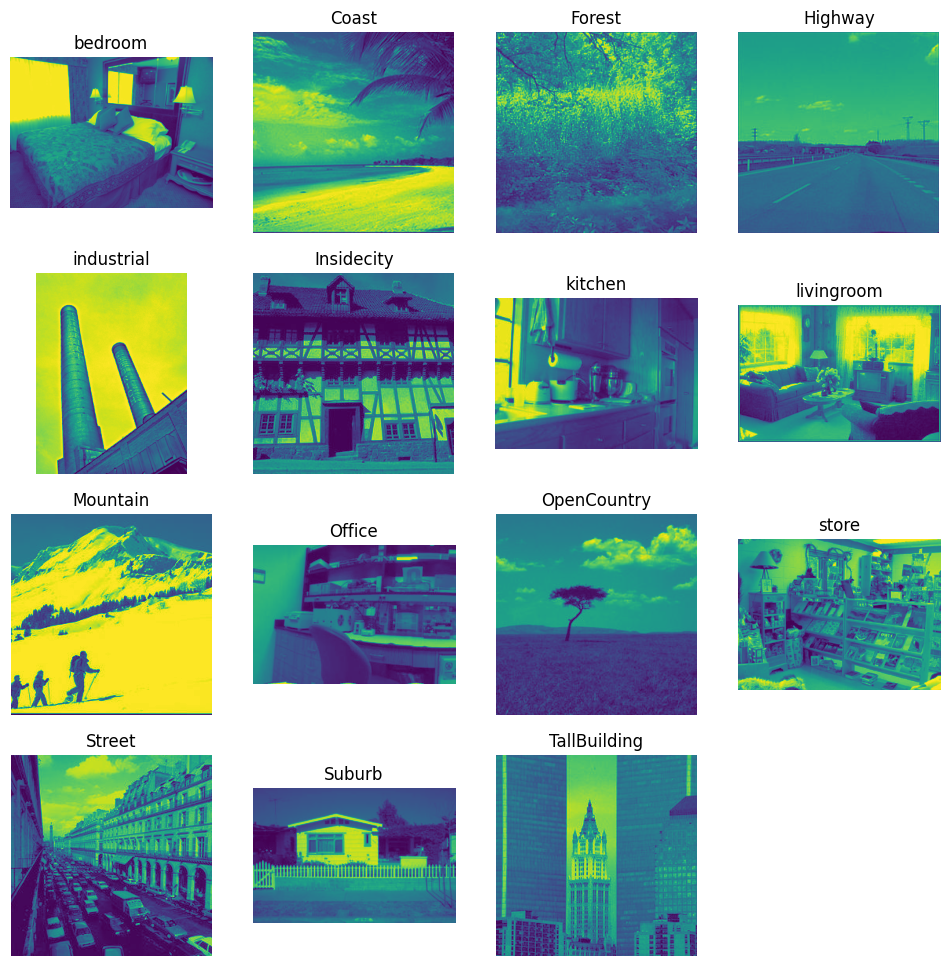

Parámetros: pixels_per_cell=(8, 8), cells_per_block=(8, 8), orientations=12, image_size=(64, 64)
Precisión del modelo SVM: 0.5466666666666666
Tiempo de ejecución: 36.62 segundos

Parámetros: pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, image_size=(64, 64)
Precisión del modelo SVM: 0.5933333333333334
Tiempo de ejecución: 26.81 segundos

Mejor configuración de parámetros:
pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, image_size=(64, 64)
Mejor precisión: 0.5933333333333334


In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.feature import hog
from skimage import data, exposure, feature, io, color
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.preprocessing import StandardScaler
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
from skimage import io, color, transform, exposure
from skimage.filters import median
import time
from sklearn.svm import SVC

testa2 = 'a2/data/test'
traina2 = 'a2/data/train'

categorias = os.listdir(traina2)


num_categories = len(categorias)
rows = 4  # Número de filas en la cuadrícula
cols = num_categories // rows + 1  # Número de columnas en la cuadrícula

plt.figure(figsize=(12, 12))

for i, category in enumerate(categorias):
    category_path = os.path.join(traina2, category) # Ruta de la categoría
    image_files = os.listdir(category_path) # Lista de archivos en la categoría
    if image_files:
        first_image_path = os.path.join(category_path, image_files[0]) # Ruta de la primera imagen
        img = imread(first_image_path) # Lectura de la imagen

    plt.subplot(rows, cols, i + 1) 
    plt.imshow(img, cmap="gray") 
    plt.axis('off') 
    plt.title(category) 
 
plt.show()



def calcular_hog_features(train_dir, categorias, pixels_per_cell, cells_per_block, orientations, image_size):
    features_list = []
    labels = []

    for i, category in enumerate(categorias):
        category_path = os.path.join(train_dir, category)
        image_files = os.listdir(category_path)

        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)

            img = io.imread(image_path, as_gray=True)
            img = transform.resize(img, image_size)

            # Ajuste de contraste adaptativo
            img = exposure.equalize_adapthist(img)
            
            features = hog(img, orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)

            features_list.append(features)
            labels.append(category)

    df = pd.DataFrame(features_list)
    df['label'] = labels

    return df


    
parametros_a_probar = [
   # ((1, 1), (1, 1), 4, (128, 128)),
    #((2, 2), (2, 2), 4, (128, 128)),
   # ((4, 4), (2, 2), 8, (128, 128)),
   # ((8, 8), (2, 2), 8, (128, 128)),
   # ((8, 8), (4, 4), 16, (64, 64)),
#(8, 8), (8, 8), 8, (64, 64)),
 #  ((8, 8), (8, 8), 8, (128, 128)),
      ((8, 8), (8, 8), 12, (64, 64)), # 0.56 EN 8segs.... 0.59 con equalize_adapthist(img)
     ((16, 16), (2, 2), 9, (64, 64)), # 0.56 EN 8segs.... 0.61 con equalize_adapthist(img)
        #  ((4, 4), (2, 2), 12, (64, 64)), # 0.56 EN 8segs.... 0.59 con equalize_adapthist(img)
         #   ((8, 8), (8, 8), 16, (128, 128)), # 0.56 EN 8segs.... 0.57 con equalize_adapthist(img)
   # ((8, 8), (8, 8), 16, (256, 256)),
]

mejor_precision = 0.0
mejores_parametros = None

for params in parametros_a_probar:
    start_time = time.time()
    df = calcular_hog_features(traina2, categorias, *params)

    # Separar características y etiquetas
    X = df.drop('label', axis=1)
    y = df['label']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Normalizar características
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    # Crear y entrenar el modelo SVM 
    svm_model = SVC(kernel='rbf') # Kernel RBF por defecto
    svm_model.fit(X_train_normalized, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = svm_model.predict(X_test_normalized)

    # Calcular la precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"Parámetros: pixels_per_cell={params[0]}, cells_per_block={params[1]}, orientations={params[2]}, image_size={params[3]}")
    print("Precisión del modelo SVM:", accuracy)
    print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")
    print()

    # Actualizar la mejor precisión y los mejores parámetros si es necesario
    if accuracy > mejor_precision:
        mejor_precision = accuracy
        mejores_parametros = params

print("Mejor configuración de parámetros:")
print(f"pixels_per_cell={mejores_parametros[0]}, cells_per_block={mejores_parametros[1]}, orientations={mejores_parametros[2]}, image_size={mejores_parametros[3]}")
print("Mejor precisión:", mejor_precision)




